## Imports and loading data

In [22]:
import tensorflow as tf
import numpy as np

In [23]:
import tensorflow_datasets as tfds
from keras.src.utils import to_categorical

(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True,  # Include labels
)

In [24]:
train_ds.shape

TensorShape([2569, 442, 1024, 3])

## Preprocessing data

In [25]:
size = (150, 150)

train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [26]:
train_ds.shape

TensorShape([2569, 150, 150, 3])

## Loading VGG16 model

In [27]:
from keras.src.applications.vgg16 import VGG16
from keras.src.applications.vgg16 import preprocess_input

train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False


In [28]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Adding Layers

In [29]:
from keras import layers, models


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')



model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


## Training model

In [30]:
from keras.src.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = model.fit(train_ds, train_labels, epochs=10, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 557ms/step - accuracy: 0.3457 - loss: 2.8159 - val_accuracy: 0.5350 - val_loss: 1.2656
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 544ms/step - accuracy: 0.6430 - loss: 0.9903 - val_accuracy: 0.6304 - val_loss: 1.1510
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 544ms/step - accuracy: 0.7600 - loss: 0.7096 - val_accuracy: 0.6751 - val_loss: 1.0560
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 539ms/step - accuracy: 0.8185 - loss: 0.5405 - val_accuracy: 0.6848 - val_loss: 1.1005
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 538ms/step - accuracy: 0.8630 - loss: 0.3731 - val_accuracy: 0.6984 - val_loss: 1.0810
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 539ms/step - accuracy: 0.8989 - loss: 0.2793 - val_accuracy: 0.6965 - val_loss: 1.1361
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 540ms/step - accuracy: 0.9229 - loss: 0.2239 - val_accuracy: 0.7062 - val_loss: 1.2440
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 543ms/step - accuracy: 0.9146 - loss: 0.2161 - val_accu

In [31]:
model.evaluate(test_ds, test_labels)

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 473ms/step - accuracy: 0.9451 - loss: 0.1997


[0.194959357380867, 0.9418710470199585]

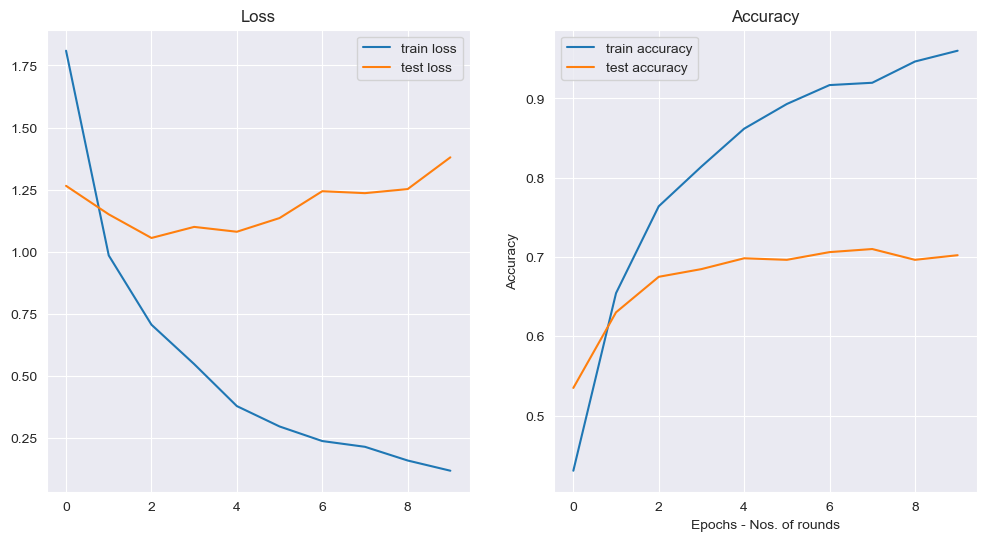

In [32]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='train loss')
axs[0].plot(history.history['val_loss'], label='test loss')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='train accuracy')
axs[1].plot(history.history['val_accuracy'], label='test accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs - Nos. of rounds')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

In [33]:
#Classification report
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

print(classification_report(y_true, y_pred, target_names=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']))

35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 448ms/step
              precision    recall  f1-score   support

       daisy       0.96      0.97      0.97       287
   dandelion       0.98      0.98      0.98       187
       roses       0.93      0.87      0.90       238
  sunflowers       0.94      0.98      0.96       191
      tulips       0.88      0.91      0.90       198

    accuracy                           0.94      1101
   macro avg       0.94      0.94      0.94      1101
weighted avg       0.94      0.94      0.94      1101



35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 434ms/step


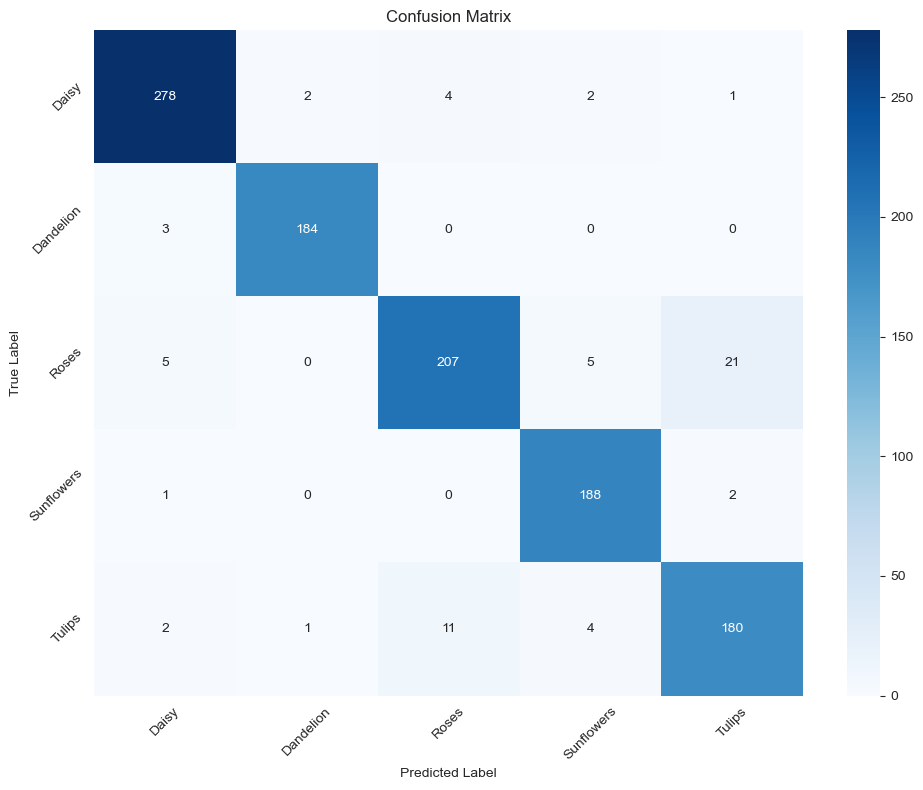

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



Detailed Classification Report:
              precision    recall  f1-score   support

       Daisy       0.96      0.97      0.97       287
   Dandelion       0.98      0.98      0.98       187
       Roses       0.93      0.87      0.90       238
  Sunflowers       0.94      0.98      0.96       191
      Tulips       0.88      0.91      0.90       198

    accuracy                           0.94      1101
   macro avg       0.94      0.94      0.94      1101
weighted avg       0.94      0.94      0.94      1101


Per-class Analysis:

Daisy:
Total samples: 287
Correct predictions: 278
Misclassifications: 9
Precision: 0.962
Recall: 0.969
Accuracy: 0.969

Dandelion:
Total samples: 187
Correct predictions: 184
Misclassifications: 3
Precision: 0.984
Recall: 0.984
Accuracy: 0.984

Roses:
Total samples: 238
Correct predictions: 207
Misclassifications: 31
Precision: 0.932
Recall: 0.870
Accuracy: 0.870

Sunflowers:
Total samples: 191
Correct predictions: 188
Misclassifications: 3
Precision:

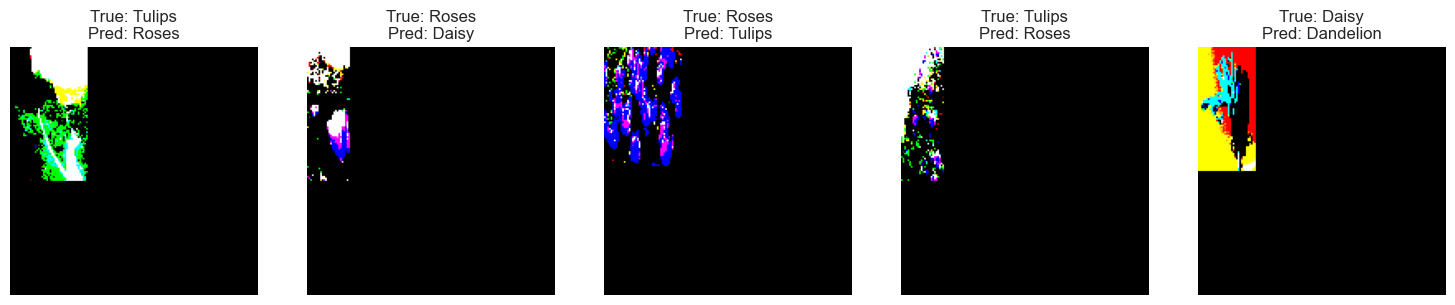

In [38]:
# Testing on multiple images
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names))

# Calculate and display additional metrics
print("\nPer-class Analysis:")
for i in range(len(class_names)):
    true_pos = cm[i][i]
    false_pos = np.sum(cm[:, i]) - true_pos
    false_neg = np.sum(cm[i, :]) - true_pos
    total = np.sum(cm[i, :])
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    class_accuracy = true_pos / total
    
    print(f"\n{class_names[i]}:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {true_pos}")
    print(f"Misclassifications: {total - true_pos}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Accuracy: {class_accuracy:.3f}")

# Visualize some misclassified examples
def plot_misclassified_examples(X_test, y_true, y_pred, class_names, n_examples=5):
    misclassified_idx = np.where(y_true_classes != y_pred_classes)[0]
    
    if len(misclassified_idx) > 0:
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(misclassified_idx[:n_examples]):
            plt.subplot(1, n_examples, i + 1)
            img = (test_ds[idx] + 1) / 2  # Denormalize
            plt.imshow(img)
            plt.title(f'True: {class_names[y_true_classes[idx]]}\nPred: {class_names[y_pred_classes[idx]]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

plot_misclassified_examples(test_ds, y_true_classes, y_pred_classes, class_names)